# Mask, Generator, Analysis - unet_s256_rings
This notebook reads in images, creates the mask targets, and uses a custom generator to randomly rotate/flip the targets.

It also analyzes the model and loss output for a given run.

In [11]:
import glob
import cv2
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load model and evaluate its performance

In [17]:
#now do this on local machine
files = glob.glob('models/*.npy')

img_i=1
data = np.load(files[img_i])
dim = data.shape[1]

models/unet_s256_rings_FL3_he_normal_pred.npy


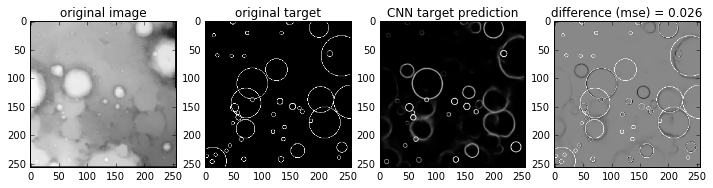

In [29]:
i=6

diff = data[i,:,:,1] - data[i,:,:,2]
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=[12, 8])
ax1.imshow(data[i,:,:,0], origin='upper', cmap="Greys_r")   #original image
ax2.imshow(data[i,:,:,1], origin='upper', cmap="Greys_r")   #original ground truth
ax3.imshow(data[i,:,:,2], origin='upper', cmap="Greys_r")   #predictions
ax4.imshow(diff, origin='upper', cmap="Greys_r")
ax1.set_title('original image')
ax2.set_title('original target')
ax3.set_title('CNN target prediction')
ax4.set_title('difference (mse) = %.3f'%(np.sum(diff**2)/(dim*dim)))
#plt.savefig('output_dir/images/%s_%d.png'%(os.path.basename(files[img_i]).split('.npy')[0],i))
print files[img_i]

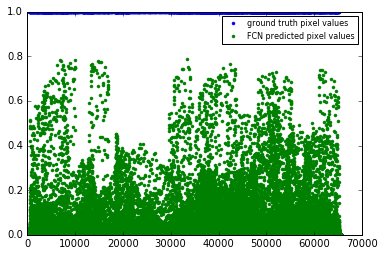

In [23]:
i=0
plt.plot(data[i,:,:,1].reshape(dim*dim), '.', label='ground truth pixel values')
plt.plot(data[i,:,:,2].reshape(dim*dim), '.', label='FCN predicted pixel values')
plt.legend(fontsize=8, numpoints=1)
#plt.savefig('output_dir/images/%s_%d_pixels.png'%(os.path.basename(files[img_i]).split('.npy')[0],i))

## Plot loss vs. epoch

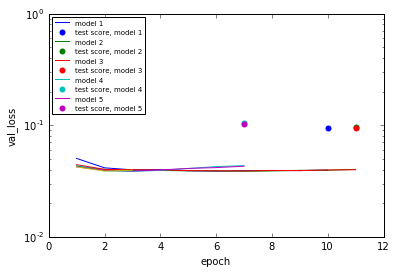

In [34]:
filename = 'output_dir/unet_s256_rings_FLinitgridsearch.txt'
#filename = 'models/good_models/FCNforkskip_imggen_lmbda0.0e+00.txt'

epoch_score, N_models = [], 0
lines = open(filename, 'r').readlines()
for line in lines:
    if "val_loss:" in line:
        epoch_score.append(float(line.split('val_loss:')[1]))
    elif "Test Score is" in line:
        N_models += 1
        test_score, n_epochs = float(line.split('Test Score is')[1]), len(epoch_score)
        p = plt.plot(np.arange(n_epochs)+1, epoch_score, label='model %d'%N_models)
        plt.plot(n_epochs, test_score, 'o', color=p[0].get_color(), mew=0, label='test score, model %d'%N_models)
        plt.legend(loc='upper left',fontsize=7, numpoints=1)
        epoch_score = []

plt.plot(np.arange(len(epoch_score))+1, epoch_score)
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.yscale('log')